In [22]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import keras_tuner as kt  ## new

In [12]:
df = pd.read_csv("diabetes.csv")

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [13]:
df.corr()["Outcome"]

Pregnancies                 0.221898
Glucose                     0.466581
BloodPressure               0.065068
SkinThickness               0.074752
Insulin                     0.130548
BMI                         0.292695
DiabetesPedigreeFunction    0.173844
Age                         0.238356
Outcome                     1.000000
Name: Outcome, dtype: float64

In [14]:
X = df.iloc[:, 0:-1].values
y = df.iloc[:, -1].values

In [15]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1)

In [17]:
X_train.shape

(614, 8)

In [13]:
model = Sequential([
    Dense(32, activation="relu", input_dim=X_train.shape[1]),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
20/20 [==============================] - 0s 11ms/step - loss: 0.7584 - accuracy: 0.4479 - val_loss: 0.7023 - val_accuracy: 0.5260
Epoch 2/10
20/20 [==============================] - 0s 6ms/step - loss: 0.6924 - accuracy: 0.5831 - val_loss: 0.6466 - val_accuracy: 0.6364
Epoch 3/10
20/20 [==============================] - 0s 6ms/step - loss: 0.6434 - accuracy: 0.6743 - val_loss: 0.6050 - val_accuracy: 0.6948
Epoch 4/10
20/20 [==============================] - 0s 5ms/step - loss: 0.6076 - accuracy: 0.7003 - val_loss: 0.5721 - val_accuracy: 0.7013
Epoch 5/10
20/20 [==============================] - 0s 5ms/step - loss: 0.5800 - accuracy: 0.7248 - val_loss: 0.5482 - val_accuracy: 0.7338
Epoch 6/10
20/20 [==============================] - 0s 5ms/step - loss: 0.5576 - accuracy: 0.7345 - val_loss: 0.5278 - val_accuracy: 0.7532
Epoch 7/10
20/20 [==============================] - 0s 5ms/step - loss: 0.5397 - accuracy: 0.7427 - val_loss: 0.5118 - val_accuracy: 0.7662
Epoch 8/10
20/20 [=

In [14]:
# 1. how to select appropriate optimizer?
# 2. No of nodes in a layer
# 3. How to select no of hidden layers?
# 4. All in one model

In [18]:
def build_model(hp): # hp = hyper parameter
    model = Sequential([
        Dense(32, activation="relu", input_dim=8),
        Dense(1, activation="sigmoid")
    ])
    
    optimizers = hp.Choice("optimizer", values=["adam", "sgd", "rmsprop", "adadelta"])
    model.compile(optimizer=optimizers, loss="binary_crossentropy", metrics=["accuracy"])
    
    return model

# build tuner object
tuner = kt.RandomSearch(build_model, objective="val_accuracy", max_trials=5)

# now search the best value
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Trial 4 Complete [00h 00m 02s]
val_accuracy: 0.44805195927619934

Best val_accuracy So Far: 0.798701286315918
Total elapsed time: 00h 00m 07s
INFO:tensorflow:Oracle triggered exit


In [19]:
# get best hyperparameter
tuner.get_best_hyperparameters()[0].values

{'optimizer': 'adam'}

In [20]:
# you can exract the best model from now
model_adam = tuner.get_best_models(num_models=1)[0]

model_adam.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                288       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [21]:
model_adam.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, initial_epoch=11, batch_size=32, verbose=False)

In [24]:
# 2. no of neurons hyperparameter
def build_model(hp):
    units = hp.Int("units", min_value=8, max_value=128, step=8)
    model = Sequential([
        Dense(units = units, activation="relu", input_dim=8),
        Dense(1, activation="sigmoid")
    ])
    
    optimizers = hp.Choice("optimizer", values=["adam", "sgd", "rmsprop", "adadelta"])
    model.compile(optimizer=optimizers, loss="binary_crossentropy", metrics=["accuracy"])
    
    return model

tuner = kt.RandomSearch(build_model, objective="val_accuracy", max_trials=5, directory="search2")

tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Trial 5 Complete [00h 00m 02s]
val_accuracy: 0.7337662577629089

Best val_accuracy So Far: 0.798701286315918
Total elapsed time: 00h 00m 09s
INFO:tensorflow:Oracle triggered exit


In [25]:
# get best hyperparameter
tuner.get_best_hyperparameters()[0].values

{'units': 72, 'optimizer': 'adam'}

In [27]:
# 3. no of layers hyperparameter
def build_model(hp):
    units = hp.Int("units", min_value=8, max_value=128)
    layers = hp.Int("layers", min_value=1, max_value=10)
    model = Sequential([
        Dense(72, activation="relu", input_dim=8)
    ])
    
    for layer in range(layers):
        model.add(Dense(72, activation="relu"))
        
    model.add(Dense(1, activation="sigmoid"))
    
    optimizers = hp.Choice("optimizer", values=["adam", "sgd", "rmsprop", "adadelta"])
    model.compile(optimizer=optimizers, loss="binary_crossentropy", metrics=["accuracy"])
    
    return model

tuner = kt.RandomSearch(build_model, objective="val_accuracy", max_trials=10)

tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Trial 10 Complete [00h 00m 03s]
val_accuracy: 0.44155845046043396

Best val_accuracy So Far: 0.8116883039474487
Total elapsed time: 00h 00m 22s
INFO:tensorflow:Oracle triggered exit


In [29]:
tuner.get_best_hyperparameters()[0].values

{'units': 81, 'layers': 4, 'optimizer': 'adam'}

In [23]:
# 4. all together
def build_model(hp):
    # set the layer hyper-parameter
    layers = hp.Int("layers", min_value=1, max_value=10)
    # define the model
    model = Sequential()
    
    for layer in range(layers):
        units = hp.Int(f"units_{layer}", min_value=8, max_value=128)
        activation = hp.Choice(f"activation_{layer}", values=["relu", "tanh", "sigmoid"])
        p = hp.Choice(f"dropout_{layer}", values=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
        
        # define the input layer
        if layer == 0:
            model.add(Dense(units=units, activation=activation, input_dim=8))
            model.add(Dropout(p))
        # define the hidden layers
        else:
            model.add(Dense(units=units, activation=activation, input_dim=8))
            model.add(Dropout(p))
            
    # define the output layer
    model.add(Dense(1, activation="sigmoid"))
    # set the optimizer and compile
    optimizers = hp.Choice("optimizer", values=["adam", "sgd", "rmsprop", "adadelta", "adagrad"])
    model.compile(optimizer=optimizers, loss="binary_crossentropy", metrics=["accuracy"])
    # and return it
    return model

# build the Search object
tuner = kt.RandomSearch(build_model, objective="val_accuracy", max_trials=70, directory="best_params", project_name="final")
# and find the best hyper parameters
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Trial 70 Complete [00h 00m 02s]
val_accuracy: 0.3571428656578064

Best val_accuracy So Far: 0.8181818127632141
Total elapsed time: 00h 02m 49s
INFO:tensorflow:Oracle triggered exit


In [19]:
tuner.get_best_hyperparameters()[0].values

{'layers': 9,
 'units_0': 88,
 'activation_0': 'tanh',
 'optimizer': 'adam',
 'units_1': 112,
 'activation_1': 'relu',
 'units_2': 24,
 'activation_2': 'sigmoid',
 'units_3': 72,
 'activation_3': 'tanh',
 'units_4': 32,
 'activation_4': 'tanh',
 'units_5': 40,
 'activation_5': 'tanh',
 'units_6': 56,
 'activation_6': 'tanh',
 'units_7': 48,
 'activation_7': 'tanh',
 'units_8': 16,
 'activation_8': 'relu',
 'units_9': 32,
 'activation_9': 'sigmoid'}

In [24]:
# now get the best model with best hyper parameters
model = tuner.get_best_models(num_models=1)[0]

# train the model
history = model.fit(X_train, y_train, epochs=200, initial_epoch=11, validation_data=(X_test, y_test), verbose=False)

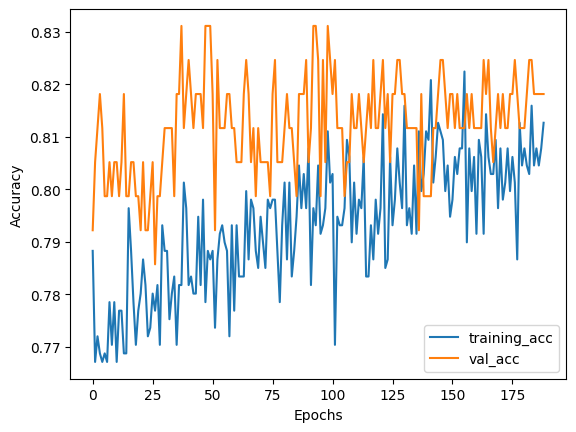

In [25]:
plt.plot(history.history["accuracy"], label="training_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()